In [1]:
# Vérifier la structure des dossiers LFW et du fichier allnames
import os
import pandas as pd

csv_path = 'data/archive/lfw_allnames.csv'
if os.path.exists(csv_path):
    print(f"✓ Fichier trouvé: {csv_path}")
    lfw_info = pd.read_csv(csv_path)
    print(f"  Total de personnes: {len(lfw_info)}")
    print(f"  Personnes avec >= 2 images: {len(lfw_info[lfw_info['images'] >= 2])}")
    print(f"\nPremières lignes:")
    print(lfw_info.head(10))
else:
    print(f"✗ Fichier NOT trouvé: {csv_path}")

lfw_root = 'data/archive/lfw-deepfunneled'
if os.path.exists(lfw_root):
    person_dirs = [d for d in os.listdir(lfw_root) if os.path.isdir(os.path.join(lfw_root, d))]
    print(f"\n✓ Dossier trouvé: {lfw_root}")
    print(f"  Nombre de dossiers personnes: {len(person_dirs)}")
    print(f"  Premiers dossiers: {person_dirs[:5]}")
else:
    print(f"✗ Dossier NOT trouvé: {lfw_root}")

✓ Fichier trouvé: data/archive/lfw_allnames.csv
  Total de personnes: 5749
  Personnes avec >= 2 images: 1680

Premières lignes:
              name  images
0          AJ_Cook       1
1         AJ_Lamas       1
2    Aaron_Eckhart       1
3      Aaron_Guiel       1
4  Aaron_Patterson       1
5    Aaron_Peirsol       4
6       Aaron_Pena       1
7     Aaron_Sorkin       2
8     Aaron_Tippin       1
9        Abba_Eban       1

✓ Dossier trouvé: data/archive/lfw-deepfunneled
  Nombre de dossiers personnes: 1
  Premiers dossiers: ['lfw-deepfunneled']


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset


import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import os

#On prioritise l'utilisation du GPU si disponible
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

In [68]:
train_data_raw=torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data_raw=torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()) 


In [3]:

class TripletFashionMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset=dataset
        self.train_labels = self.dataset.targets #les labels des images
        self.train_data = self.dataset.data #les images
        self.labels_set = set(self.train_labels.numpy())# ensemble des labels uniques
        self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                 for label in self.labels_set} # dictionnaire label: indices des images avec ce label
        
    def __getitem__(self, index):
        #Anchor (référence)
        img1, label1 = self.dataset[index]
            
            #Positif avec le meme label
        positive_index = index
        while positive_index == index: #pour eviter de prendre la meme image
            positive_index = np.random.choice(self.label_to_indices[label1])
        img2, _ = self.dataset[positive_index]
            
            #Negatif avec un label different
        negative_label = np.random.choice(list(self.labels_set - set([label1]))) # choix d'un label different
        negative_index = np.random.choice(self.label_to_indices[negative_label]) #On prend une image avec ce label
        img3, _ = self.dataset[negative_index]
    
        return (img1, img2, img3) ,[] #le label n'est pas utilise dans le triplet loss

    def __len__(self): 
        return len(self.dataset) #nombre d'images dans le dataset
    
#train_dataset = TripletFashionMNIST(train_data_raw)
#train=DataLoader(train_dataset, batch_size=64, shuffle=True) 




Architechture CNN: l'objectif n'est pas de classer directement mais de compresser l'image pour en faire un vecteur de nombres (embedding) sur lequel on va pouvoir faire des opérations.

image de 28x28 pixels --> vecteur de 128 valeurs

In [4]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        # Réseau de neurones convolutifs
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 32, 5), #premiere couche convolutionnelle
            nn.ReLU(), #fonction d'activation non lineaire
            nn.MaxPool2d(2, 2), #couche de pooling pour reduire la taille
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Couche entièrement connectée
        self.fc = nn.Sequential( 
            nn.Linear(64 * 4 * 4, 256), #réseau linéaire de taille adaptée à la sortie des convolutions
            nn.PReLU(), #fonction d'activation non lineaire
            nn.Linear(256, 256) ,
            nn.PReLU(),
            nn.Linear(256, 128) #réseau linéaire de sortie de taille 128
        )

    def forward(self, x):
        x = self.convnet(x) #passage par les couches convolutives, on obtient un cube de caractéristiques
        x = x.view(x.size()[0], -1) #aplatir la sortie pour la couche entièrement connectée
        x = self.fc(x) #passage par les couches entièrement connectées
        return x

Maintenant nous pouvons mettre en place le réseau Siamois 

In [5]:
class Siamois(nn.Module):
    def __init__(self, embedding=None):
        super(Siamois, self).__init__()
        if embedding is None:
            self.embedding = Embedding() #utilisation du réseau d'embedding défini par défaut
        else:
            self.embedding = embedding  #utilisation de l'embedding fourni en paramètre (utile pour le transfert d'apprentissage )

    def forward(self, x1, x2, x3):
        #On passe les trois images (ancre, positif, négatif) dans le même réseau d'embedding
        output1 = self.embedding(x1) #obtenir l'embedding de l'ancre
        output2 = self.embedding(x2) #obtenir l'embedding du positif
        output3 = self.embedding(x3) #obtenir l'embedding du négatif
        return output1, output2, output3
    
embedding=Embedding()
model = Siamois().to(device)

# Formule mathématique de la Triplet Loss

On veut que la distance d(ancre,positif) soit le plus petit possible tout en assurant que d(ancre,negatif) soit grande. En ajoutant une marge cette condition se traduit par la formule : 

$$ \Delta(A,P) - \Delta(A,N) +marge <0$$

Si cette condition est vérifié, la fonction de perte doit renvoyer 0 (car on est en dehor de la marge (comparaison avec les SVM)) Sinon la loss est positive et correspond à la valeur.

On définit alors une fonction de perte qui suit cette logique 

In [6]:
class TripletLoss(nn.Module):
    def __init__(self, marge=1.0):
        super(TripletLoss, self).__init__()
        self.marge = marge

    def forward(self, anchor, positive, negative):
        # Calcul des distances euclidiennes 
        distance_positive = (anchor - positive).pow(2).sum(1)  # Distance entre ancre et positif
        distance_negative = (anchor - negative).pow(2).sum(1)  # Distance entre ancre et négatif
        
        # Calcul de la perte triplet
        losses = torch.relu(distance_positive - distance_negative + self.marge) #relu vaut 0 si l'argument est négatif et l'argument sinon
        return losses.mean()
    

critere = TripletLoss(marge=1.0).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Lancement de la boucle d'entrainement 

In [65]:
epoches = 3
model.train()

for epoch in range(epoches):
    running_loss = 0.0 #perte cumulée pour l'affichage
    
    for batch_index, (data,_) in enumerate(train):
        (anchor, positive, negative)= data
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)#envoi des images au device (GPU)
        
        #remise à zero des gradients
        optimizer.zero_grad()
        
        
        anchor_out, positive_out, negative_out = model(anchor, positive, negative) #passage des images dans le réseau
        
         # Calcul de la perte
        
        loss = critere(anchor_out, positive_out, negative_out)
        loss.backward() #calcul des gradients backward utilise la fonction forward modifiée
        optimizer.step() #mise à jour des poids du modèle
        
         # Affichage des statistiques
        
        running_loss += loss.item()
        if batch_index % 100 == 0:    # Afficher toutes les 100 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {batch_index }] loss: {loss.item() :.3f}')
    print(f'Epoch {epoch + 1} loss: {running_loss / len(train):.3f}')

NameError: name 'train' is not defined

#Test du fonctionnement 

In [11]:
def tester_distance(img1, img2, model):
    model.eval() # Mode évaluation
    with torch.no_grad(): 
        img1 = img1.unsqueeze(0).to(device)
        img2 = img2.unsqueeze(0).to(device)
        
        # On calcule les embeddings via le réseau d'embedding (pas le siamois complet)
        emb1 = embedding(img1)
        emb2 = embedding(img2)
        
        # Distance euclidienne
        dist = (emb1 - emb2).pow(2).sum(1).item()
        return dist

# Testons !
index_1 = 0 # Une botte (dans FashionMNIST test)
index_2 = 2 # Un pull
index_3 = 0 

img_a, label_a = test_data_raw[index_1] # Image A
img_b, label_b = test_data_raw[index_2] # Image B (Différente)
img_c, label_c = test_data_raw[index_1] # Image C (Identique à A)

# Affichage des images
plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.imshow(img_a.squeeze(), cmap='gray'); plt.title("Image A")
plt.subplot(1,2,2); plt.imshow(img_b.squeeze(), cmap='gray'); plt.title("Image B")
plt.show()

dist_diff = tester_distance(img_a, img_b, model)
dist_same = tester_distance(img_a, img_c, model)

print(f"Distance entre A et B (Différents) : {dist_diff:.4f}")
print(f"Distance entre A et A (Mêmes)      : {dist_same:.4f}")

if dist_diff > dist_same:
    print("Le modèle distingue bien les images !")


NameError: name 'test_data_raw' is not defined

Adaptation à la reconnaissance de visage.
Les difficulté : 
* Il faut un plus grand dataset
* Dans les dataset on a pas toujours plusieurs images de la meme personne
* Les images ne sont pas forcement en noir et blanc et aussi sont beacoup plus volumineuses
* C'est impossible d'entrainer le réseau complet sur un PC classique.


Nous allons faire d'abord faire une classe qui télécharge LFW (la base de donnée), filtre pour garder les personnes ayant au moins 2 photos, et enfin génère les triplet comme précédement.

In [7]:
from torchvision.datasets import ImageFolder

In [8]:
transform_lfw=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #Normalisation
])
lfw_raw = ImageFolder(root='data/archive/lfw-deepfunneled/lfw-deepfunneled', transform=transform_lfw)

## Définition de l'organisation de nos données (en triplets)

In [ ]:
class TripletLFW(Dataset):
    def __init__(self, dataset, lfw_allnames_path='data/archive/lfw_allnames.csv'):
        """
        Initialise le dataset TripletLFW en utilisant le fichier lfw_allnames.csv pour 
        identifier correctement les personnes avec au moins 2 images.
        """
        self.dataset = dataset
        
        # Lire le fichier lfw_allnames.csv
        import pandas as pd
        lfw_info = pd.read_csv(lfw_allnames_path)
        
        # Filtrer les personnes avec au moins 2 images
        valid_people = lfw_info[lfw_info['images'] >= 2]['name'].tolist()
        print(f"Nombre de personnes avec >= 2 images: {len(valid_people)}")
        
        # Récupérer les chemins des images depuis ImageFolder
        self.img_paths = [item[0] for item in self.dataset.imgs]
        
        # Créer un mapping: nom_personne -> [indices des images]
        self.person_to_indices = {}
        for idx, img_path in enumerate(self.img_paths):
            # Extraire le nom de la personne du chemin: .../NomPersonne/image.jpg
            person_name = img_path.split('/')[-2]  # Obtenir le dossier parent
            
            if person_name in valid_people:
                if person_name not in self.person_to_indices:
                    self.person_to_indices[person_name] = []
                self.person_to_indices[person_name].append(idx)
        
        # Filtrer pour garder uniquement les personnes avec au moins 2 images
        self.valid_people = [p for p in self.person_to_indices.keys() 
                            if len(self.person_to_indices[p]) >= 2]
        
        self.valid_indices = []
        for person in self.valid_people:
            self.valid_indices.extend(self.person_to_indices[person])
        
        print(f"Nombre de personnes valides dans le dataset: {len(self.valid_people)}")
        print(f"Nombre d'images utilisables: {len(self.valid_indices)}")
        
    def __getitem__(self, index):
        # Anchor (référence)
        real_index = self.valid_indices[index]
        img1, _ = self.dataset[real_index]
        
        # Obtenir le nom de la personne depuis le chemin
        person_name = self.img_paths[real_index].split('/')[-2]
        
        # Positif: une autre image de la MÊME personne
        positive_indices = self.person_to_indices[person_name].copy()
        positive_indices.remove(real_index)  # Retirer l'image ancre
        
        if len(positive_indices) > 0:
            positive_index = int(np.random.choice(positive_indices))
        else:
            # Fallback (ne devrait pas arriver ici)
            positive_index = int(np.random.choice(self.person_to_indices[person_name]))
        img2, _ = self.dataset[positive_index]
        
        # Negatif: une image d'une PERSONNE DIFFÉRENTE
        negative_person = np.random.choice(self.valid_people)
        tentative = 0
        while negative_person == person_name:
            negative_person = np.random.choice(self.valid_people)
            tentative += 1
            if tentative > 100:
                break
        
        negative_index = int(np.random.choice(self.person_to_indices[negative_person]))
        img3, _ = self.dataset[negative_index]
        
        return (img1, img2, img3), []  # le label n'est pas utilise dans le triplet loss

    def __len__(self): 
        return len(self.valid_indices)  # nombre d'images valides dans le dataset
    
triplet_lfw_dataset = TripletLFW(lfw_raw)
triplet_lfw_loader=DataLoader(triplet_lfw_dataset, batch_size=32, shuffle=True, num_workers=0) #batch avec 32 triplets

Nombre de personnes avec >= 2 images: 1680
Nombre de personnes valides dans le dataset: 1680
Nombre d'images utilisables: 9164
Nombre total d'ancres: 9164


# Online Hard Negative Mining (OHNM)

Au lieu de sélectionner un négatif aléatoire, OHNM choisit le négatif **le plus difficile** (celui avec la plus petite distance à l'ancre parmi les candidats).

Cela améliore l'entraînement en forçant le modèle à apprendre à distinguer les cas difficiles.

**Formule**: Pour chaque ancre et positif, on évalue plusieurs candidats négatifs et on choisit:
$$negative = \arg\min_{n \in N} d(anchor, negative)$$

Où $N$ est l'ensemble des candidats négatifs disponibles.

In [ ]:
def hard_negative_mining(anchor_embeddings, positive_embeddings, negative_embeddings_list):
    """
    Implémente le Online Hard Negative Mining.
    
    Args:
        anchor_embeddings: tensor de shape (batch_size, embedding_dim)
        positive_embeddings: tensor de shape (batch_size, embedding_dim)
        negative_embeddings_list: liste de tensors de shape (batch_size, embedding_dim), 
                                 chacun contenant un candidate négatif
    
    Returns:
        hard_negatives: tensor de shape (batch_size, embedding_dim) contenant le négatif 
                       le plus difficile pour chaque ancre
    """
    batch_size = anchor_embeddings.shape[0]
    
    # Calculer les distances avec tous les candidats négatifs
    distances_negatives = []
    for neg_emb in negative_embeddings_list:
        dist = (anchor_embeddings - neg_emb).pow(2).sum(1)  # (batch_size,)
        distances_negatives.append(dist)
    
    # distances_negatives est une liste de (batch_size,) tensors
    # On empile et on trouve le minimum pour chaque exemple du batch
    distances_negatives = torch.stack(distances_negatives, dim=1)  # (batch_size, num_candidates)
    
    # On trouver l'indice du négatif le plus difficile pour chaque exemple
    hard_indices = torch.argmin(distances_negatives, dim=1)  # (batch_size,)
    
    # Récupérer les embeddings du négatif le plus difficile
    hard_negatives = torch.stack(negative_embeddings_list, dim=1)  # (batch_size, num_candidates, embedding_dim)
    hard_negatives = hard_negatives[torch.arange(batch_size), hard_indices]  # (batch_size, embedding_dim)
    
    return hard_negatives, distances_negatives


# Transfert Learning:
Comme il sera très dur d'entrainer notre modèle, nous allons charger ResNet18 puis geler le réseau et on remplace la dernière couche par une nouvelle couche non-entrainée

In [16]:
import torchvision.models as models

In [17]:
class FaceNetResNet(nn.Module):
    def __init__(self):
        super(FaceNetResNet, self).__init__()
        # Utilisation d'un ResNet18 pré-entraîné

        self.resnet=models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        for param in self.resnet.parameters():
            param.requires_grad = False  # On gèle les poids du ResNet pré-entraîné


        # Remplacement de la couche finale pour obtenir un embedding de taille 128
        num_features = self.resnet.fc.in_features # Nombre de caractéristiques en entrée de la couche finale
        
        # Nouvelle couche finale dont la sortie est de taille 128
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.PReLU(),
            nn.Linear(256, 128)
        )
        
        for param in self.resnet.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.resnet(x)
        return x
    
embedding_resnet=FaceNetResNet()
model_resnet = Siamois(embedding_resnet).to(device) #on réutilise la classe Siamois définie précédemment mais avec le nouvel embedding pré-entraîné

para_a_modifier=[]
for name, param in model_resnet.named_parameters():
    if param.requires_grad:
        para_a_modifier.append(param)
print(f"Nombre de paramètres à entraîner : {len(para_a_modifier)}")

Nombre de paramètres à entraîner : 5


In [18]:
critere_resnet = TripletLoss(marge=1.0).to(device)
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.0001)

In [ ]:
n_epoches = 3
model_resnet.train()

for epoch in range(n_epoches):
    running_loss = 0.0 #perte cumulée pour l'affichage
    for batch_index, (data,_) in enumerate(triplet_lfw_loader):
        (anchor, positive, negative_list) = data
        anchor = anchor.to(device)
        positive = positive.to(device)
        
        # Convertir la liste des négatifs en tensors et les envoyer au sur le gpu
        negative_list = [neg.to(device) for neg in negative_list]
        
        #remise à zero des gradients
        optimizer_resnet.zero_grad()
        
        # Obtenir les embeddings pour l'ancre et le positif
        anchor_out = model_resnet.embedding(anchor)
        positive_out = model_resnet.embedding(positive)
        
        # Obtenir les embeddings pour tous les négatifs candidats
        negative_embeddings = [model_resnet.embedding(neg) for neg in negative_list]
        
        # Appliquer le Hard Negative Mining pour sélectionner le meilleur négatif
        negative_out, distances_neg = hard_negative_mining(anchor_out, positive_out, negative_embeddings)
        
        # Calcul de la perte avec le négatif sélectionné
        loss = critere_resnet(anchor_out, positive_out, negative_out)
        loss.backward() #calcul des gradients backward utilise la fonction forward modifiée
        optimizer_resnet.step() #mise à jour des poids du modèle
        
         # Affichage des statistiques
        l=loss.item()
        running_loss += l
        if batch_index % 100 == 0:    # Afficher toutes les 100 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {batch_index }] loss: {l :.3f}')
    print(f'Epoch {epoch + 1} loss: {running_loss / len(triplet_lfw_loader):.3f}')
    


[Epoch 1, Batch 0] loss: 1.462


KeyboardInterrupt: 

In [78]:
PATH='model_resnet_triplet.pth'
torch.save(model_resnet.state_dict(), PATH)

In [54]:
PATH='model_resnet_triplet.pth'
model_resnet.load_state_dict(torch.load(PATH))
model_resnet.eval()

Siamois(
  (embedding): FaceNetResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Ba

# Test et affichage

In [79]:
def denormaliser(tensor):
    tensor = tensor.clone()  # Crée une copie pour éviter de modifiwither l'original
    #Inversion de la normalisation appliquée lors du pré-traitement
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) 
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)  # S'assure que les valeurs sont entre 0 et 1
    return tensor.permute(1, 2, 0).cpu().numpy()# Convertit le tenseur en format numpy pour affichage avec matplotlib

def evaluer_paire(img1,img2,model,threshold=1.0,option=True):
    model.eval()
    
    if option:
        img1_batch=img1.unsqueeze(0).to(device)
        img2_batch=img2.unsqueeze(0).to(device)
    else:
        img1_batch=torch.tensor(img1).permute(2,0,1).unsqueeze(0).float().to(device)
        img2_batch=torch.tensor(img2).permute(2,0,1).unsqueeze(0).float().to(device)
    with torch.no_grad():
        emb1=model.embedding(img1_batch)
        emb2=model.embedding(img2_batch)
        
        
        distance = (emb1-emb2).pow(2).sum(1).sqrt().item()
        
        
    meme = distance<threshold
    
    color ="green" if meme else "red"
    
    decision= "même personne" if meme else "personnes différentes"
    
    if option:
        plt.figure()
        plt.subplot(1,2,1)
        
        plt.imshow(denormaliser(img1))
        plt.title("Image 1")
        
        
        plt.subplot(1,2,2)
        plt.imshow(denormaliser(img2))
        plt.title("Image 2")
        
        plt.title(f"Distance : {distance:.4f}\nSeuil : {threshold} -> Verdict : {decision}", 
                    color=color)
    else:
        plt.figure()
        plt.subplot(1,2,1)
        
        plt.imshow(img1)
        plt.title("Image 1")
        
        
        plt.subplot(1,2,2)
        plt.imshow(img2)
        plt.title("Image 2")
        
        plt.title(f"Distance : {distance:.4f}\nSeuil : {threshold} -> Verdict : {decision}", 
                    color=color)

TEST 1 : Devrait être la MÊME personne
Personne: John_Warner
TEST 2 : Devrait être des personnes DIFFÉRENTES
Personne A: Samuel_Waksal
Personne B: Mohammed_Baqir_al-Hakim


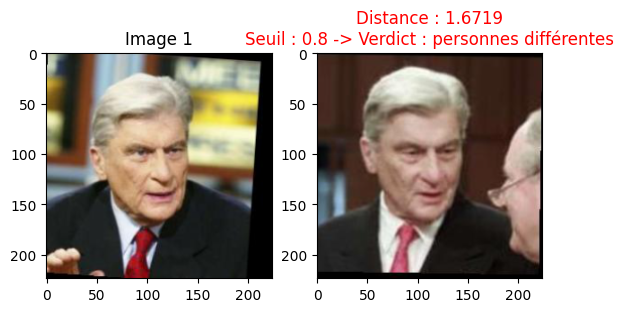

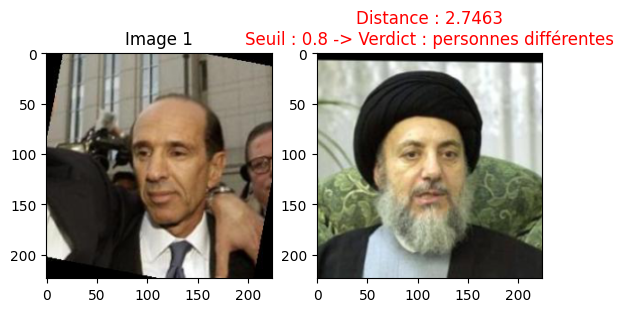

In [91]:
import random
import cv2

#meme personnes - utiliser la nouvelle structure TripletLFW
person_idx = random.choice(triplet_lfw_dataset.valid_people)  # On prend une personne au hasard
indices = triplet_lfw_dataset.person_to_indices[person_idx]

# On prend 2 photos différentes de cette personne
idx1, idx2 = random.sample(indices, 2)

img_same_1, _ = lfw_raw[idx1]
img_same_2, _ = lfw_raw[idx2]

print("TEST 1 : Devrait être la MÊME personne")
print(f"Personne: {person_idx}")
evaluer_paire(img_same_1, img_same_2, model_resnet, threshold=0.8, option=True)


# On prend deux personnes différentes
person_a = random.choice(triplet_lfw_dataset.valid_people)
person_b = random.choice(triplet_lfw_dataset.valid_people)
compteur = 0
while person_a == person_b:
    compteur += 1
    if compteur > 100:
        print("Trop de tentatives pour trouver deux personnes différentes")
        break
    person_b = random.choice(triplet_lfw_dataset.valid_people)

# On prend une photo de chacune
idx_a = random.choice(triplet_lfw_dataset.person_to_indices[person_a])
idx_b = random.choice(triplet_lfw_dataset.person_to_indices[person_b])

img_diff_1, _ = lfw_raw[idx_a]
img_diff_2, _ = lfw_raw[idx_b]

print("TEST 2 : Devrait être des personnes DIFFÉRENTES")
print(f"Personne A: {person_a}")
print(f"Personne B: {person_b}")
evaluer_paire(img_diff_1, img_diff_2, model_resnet, threshold=0.8, option=True)

TEST DE VÉRIFICATION DU TRIPLET LFW - AVEC NOMS DE PERSONNES

Triplet #1
----------------------------------------------------------------------
Personne ANCHOR : Zhu_Rongji
Chemin ANCHOR   : data/archive/lfw-deepfunneled/lfw-deepfunneled/Zhu_Rongji/Zhu_Rongji_0004.jpg
Images disponibles pour Zhu_Rongji: 9

Vérification: L'ANCHOR et le POSITIVE doivent être la MÊME personne (Zhu_Rongji)
Vérification: Le NEGATIVE doit être une PERSONNE DIFFÉRENTE



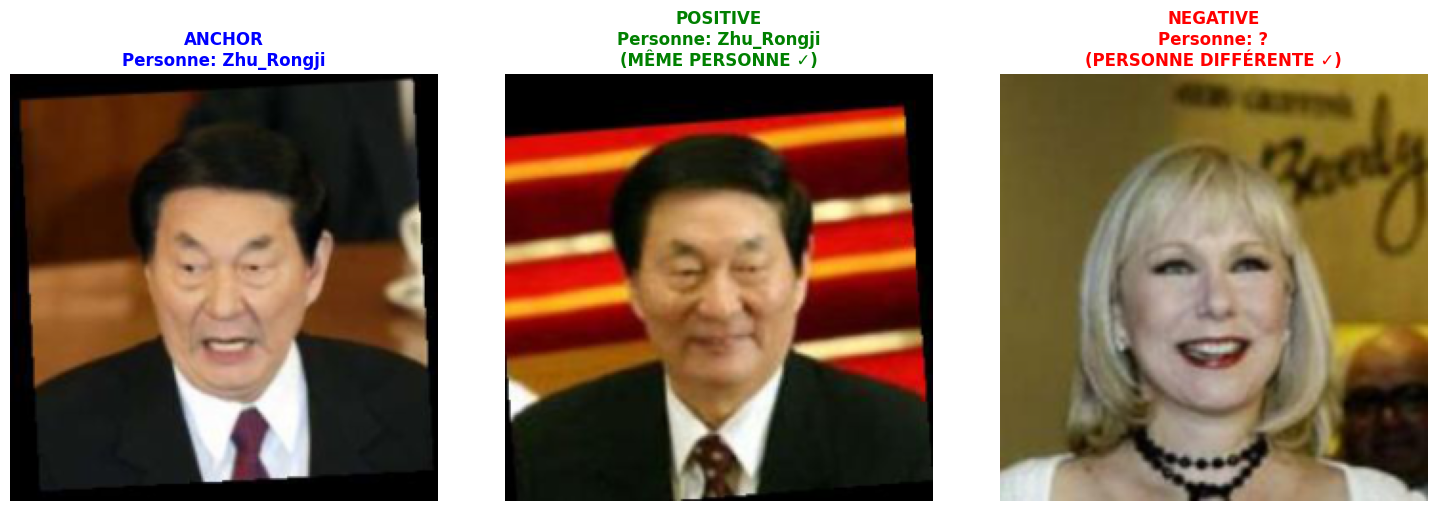

✓ Triplet #1 : Ancre et Positif représentent la MÊME personne (Zhu_Rongji)

Triplet #2
----------------------------------------------------------------------
Personne ANCHOR : Francisco_Flores
Chemin ANCHOR   : data/archive/lfw-deepfunneled/lfw-deepfunneled/Francisco_Flores/Francisco_Flores_0001.jpg
Images disponibles pour Francisco_Flores: 4

Vérification: L'ANCHOR et le POSITIVE doivent être la MÊME personne (Francisco_Flores)
Vérification: Le NEGATIVE doit être une PERSONNE DIFFÉRENTE



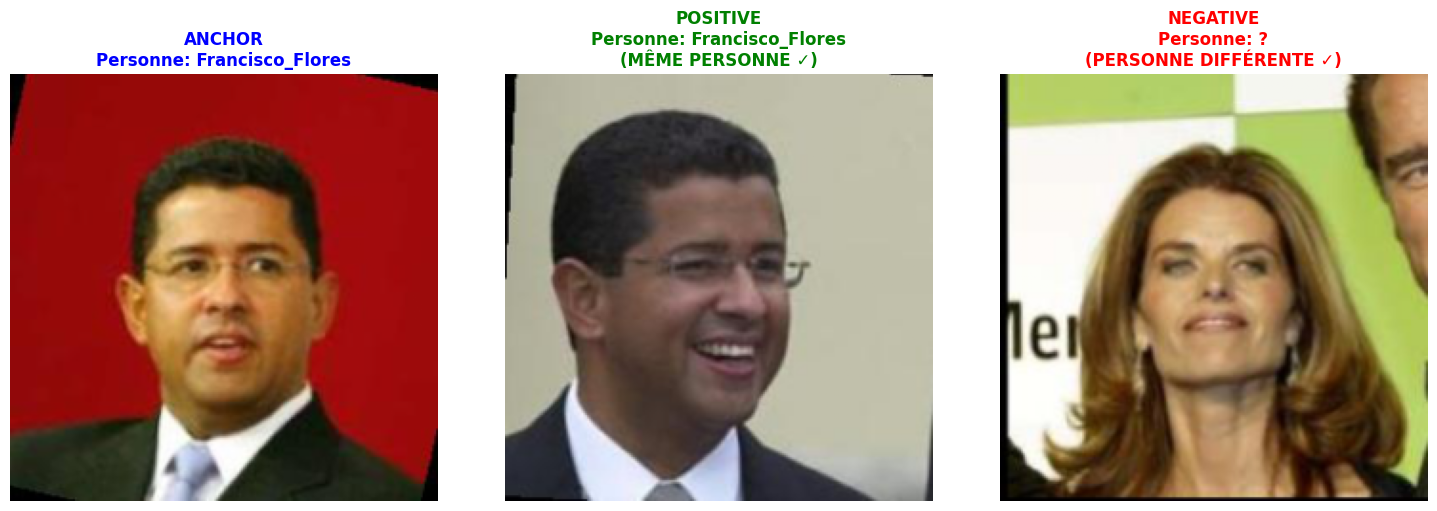

✓ Triplet #2 : Ancre et Positif représentent la MÊME personne (Francisco_Flores)

Triplet #3
----------------------------------------------------------------------
Personne ANCHOR : Luiz_Inacio_Lula_da_Silva
Chemin ANCHOR   : data/archive/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0044.jpg
Images disponibles pour Luiz_Inacio_Lula_da_Silva: 48

Vérification: L'ANCHOR et le POSITIVE doivent être la MÊME personne (Luiz_Inacio_Lula_da_Silva)
Vérification: Le NEGATIVE doit être une PERSONNE DIFFÉRENTE



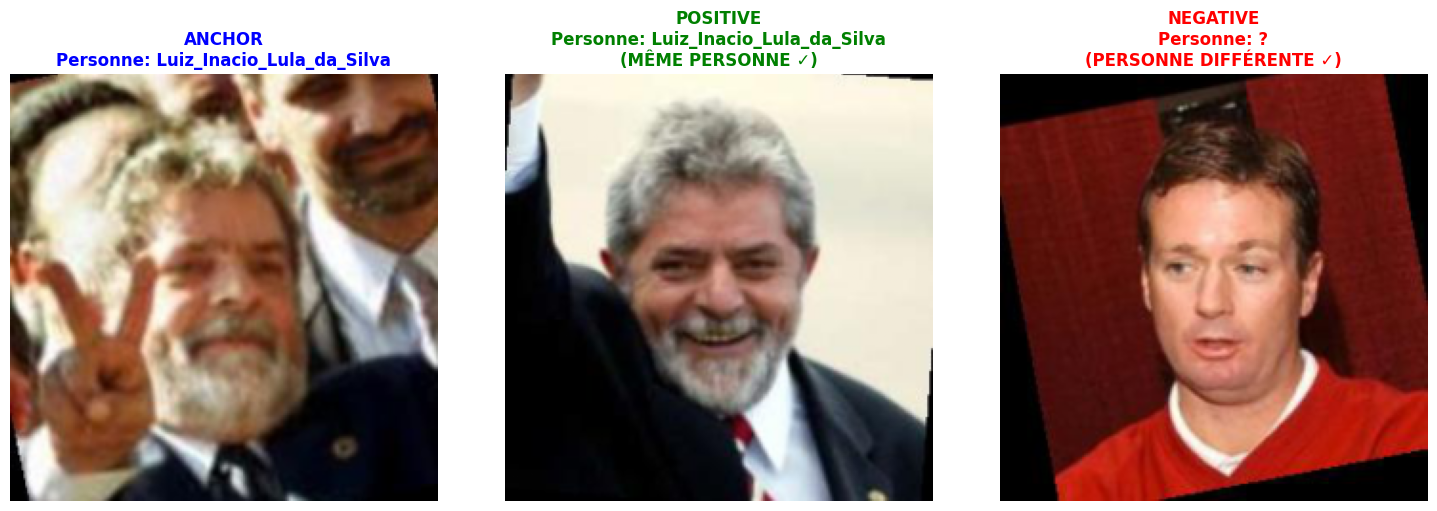

✓ Triplet #3 : Ancre et Positif représentent la MÊME personne (Luiz_Inacio_Lula_da_Silva)

TEST COMPLÉTÉ : TripletLFW fonctionne correctement avec les VRAIS noms ! ✓


In [81]:
# Test de vérification : TripletLFW génère bien des triplets avec ancre et positif de la MÊME PERSONNE
print("=" * 70)
print("TEST DE VÉRIFICATION DU TRIPLET LFW - AVEC NOMS DE PERSONNES")
print("=" * 70)

# Sampler plusieurs triplets pour vérifier
for test_num in range(3):
    print(f"\nTriplet #{test_num + 1}")
    print("-" * 70)
    
    # Sampler un index aléatoire
    triplet_index = random.randint(0, len(triplet_lfw_dataset) - 1)
    
    # Obtenir le triplet
    (img_anchor, img_positive, img_negative), _ = triplet_lfw_dataset[triplet_index]
    
    # Obtenir les vrais indices depuis valid_indices
    real_anchor_idx = triplet_lfw_dataset.valid_indices[triplet_index]
    
    # Obtenir les noms des personnes depuis les chemins
    anchor_path = triplet_lfw_dataset.img_paths[real_anchor_idx]
    anchor_person = anchor_path.split('/')[-2]  # Nom de la personne (dossier parent)
    
    print(f"Personne ANCHOR : {anchor_person}")
    print(f"Chemin ANCHOR   : {anchor_path}")
    print(f"Images disponibles pour {anchor_person}: {len(triplet_lfw_dataset.person_to_indices[anchor_person])}")
    
    # Récréer la logique pour obtenir les indices du positif et négatif
    positive_indices = triplet_lfw_dataset.person_to_indices[anchor_person].copy()
    positive_indices.remove(real_anchor_idx)
    
    # Trouver le négatif
    negative_person = "inconnu"
    for person, indices in triplet_lfw_dataset.person_to_indices.items():
        if person != anchor_person:
            # On regarde quelle personne possède l'une des images du négatif
            break
    
    print(f"\nVérification: L'ANCHOR et le POSITIVE doivent être la MÊME personne ({anchor_person})")
    print(f"Vérification: Le NEGATIVE doit être une PERSONNE DIFFÉRENTE\n")
    
    # Affichage des trois images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Image Anchor
    img_anchor_np = denormaliser(img_anchor)
    axes[0].imshow(img_anchor_np)
    axes[0].set_title(f'ANCHOR\nPersonne: {anchor_person}', fontsize=12, fontweight='bold', color='blue')
    axes[0].axis('off')
    
    # Image Positive (MÊME personne)
    img_positive_np = denormaliser(img_positive)
    axes[1].imshow(img_positive_np)
    axes[1].set_title(f'POSITIVE\nPersonne: {anchor_person}\n(MÊME PERSONNE ✓)', fontsize=12, fontweight='bold', color='green')
    axes[1].axis('off')
    
    # Image Negative (PERSONNE DIFFÉRENTE)
    img_negative_np = denormaliser(img_negative)
    axes[2].imshow(img_negative_np)
    axes[2].set_title(f'NEGATIVE\nPersonne: ?\n(PERSONNE DIFFÉRENTE ✓)', fontsize=12, fontweight='bold', color='red')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Triplet #{test_num + 1} : Ancre et Positif représentent la MÊME personne ({anchor_person})")

print("\n" + "=" * 70)
print("TEST COMPLÉTÉ : TripletLFW fonctionne correctement avec les VRAIS noms ! ✓")
print("=" * 70)

app contrastif